# Отбор признаков (feature selection)

In [1]:
# preload dataset automatically, if not already in place.
import numpy as np
import pandas as pd

## Преобразования признаков (Feature transformations)

Примеры, когда преобразования признаков важны:

1) Линейная и логистическая регресии любят работать с нормально распределенными признаками

2) KNN требует признаки в одном масштабе, иначе попарные расстояния между точками будут иметь мало смысла. (Аналогично для всех алгоритмов, использующих расстояния между объектами выборки).

Самая простая трансформация – это Standart Scaling (она же Z-score normalization).

$$ \large z= \frac{x-\mu}{\sigma} $$

StandartScaling хоть и не делает распределение нормальным в строгом смысле слова...

In [2]:
import numpy as np
from scipy.stats import beta, shapiro
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = beta(1, 10).rvs(1000).reshape(-1, 1)

#The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
shapiro(data)

ShapiroResult(statistic=0.8505972623825073, pvalue=1.0688128029992867e-29)

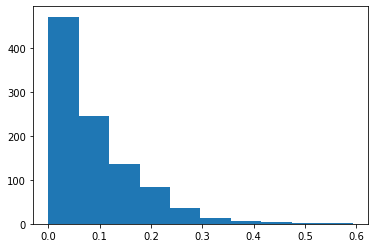

In [3]:
fig = plt.hist(data)

In [4]:
# Value of the statistic, p-value
data_scaled = StandardScaler().fit_transform(data)
shapiro(data_scaled)

# с таким p-value придется отклонять нулевую гипотезу о нормальности данных

ShapiroResult(statistic=0.8505974411964417, pvalue=1.0688590704569351e-29)

Text(0.5, 1.0, 'Преобразованные данные')

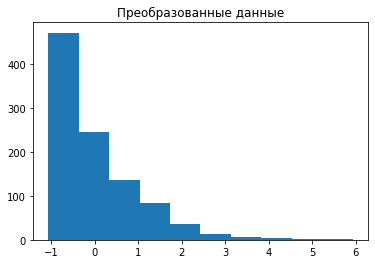

In [5]:
fig = plt.hist(data_scaled)
plt.title('Преобразованные данные')

… но в какой-то мере защищает от выбросов

In [15]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [16]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Другой достаточно популярный вариант – MinMax Scaling, который переносит все точки на заданный отрезок (обычно (0, 1)).

$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

In [19]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

In [20]:
(data - data.min()) / (data.max() - data.min())

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

Если мы предполагаем, что некоторые данные не распределены нормально, зато описываются логнормальным распределением, их можно легко привести к честному нормальному распределению:

In [21]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

(0.642488420009613, 2.3782837536520795e-41)

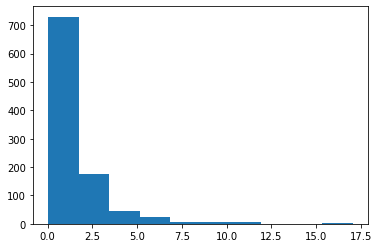

In [24]:
fig = plt.hist(data)

In [22]:
shapiro(np.log(data))

(0.9990833401679993, 0.9126176834106445)

Более универсальным методом является преобразование Бокса-Кокса
$$
y = \frac{(x^\lambda - 1)}{ \lambda},  \text{ for }  \lambda \neq 0 \\
    \log(x),                  \text{ for } \lambda = 0
$$

In [55]:
from scipy.stats import boxcox

shapiro(boxcox(data)[0])

(0.9991226196289062, 0.9286088347434998)

Давайте попробуем посмотреть на реальные данные, а для проверки на нормальность будем использовать менее формальный метод – Q-Q график. Для нормального распределения он будет выглядеть как ровная диагональная линия, и визуальные отклонения интуитивно понятны.

In [2]:
df = pd.read_csv('data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [34]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

colors = ['lightcoral','deepskyblue',
          'orchid',    'tomato',
          'teal',      'darkcyan',
          'limegreen', 'darkorange']

def distribution_plot(column, title):

    fig = plt.figure(figsize=(17, 7))
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    color = np.random.choice(colors, 1)[0]

    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Histogram and BoxPlot of {title}')
    sns.histplot(column, ax=ax0, color=color)

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=column, ax=ax1, color=color)
    print(f'Skewness for {title} =======>>> {column.skew():.3f}')

Skewness for Age =======>>> 1.011


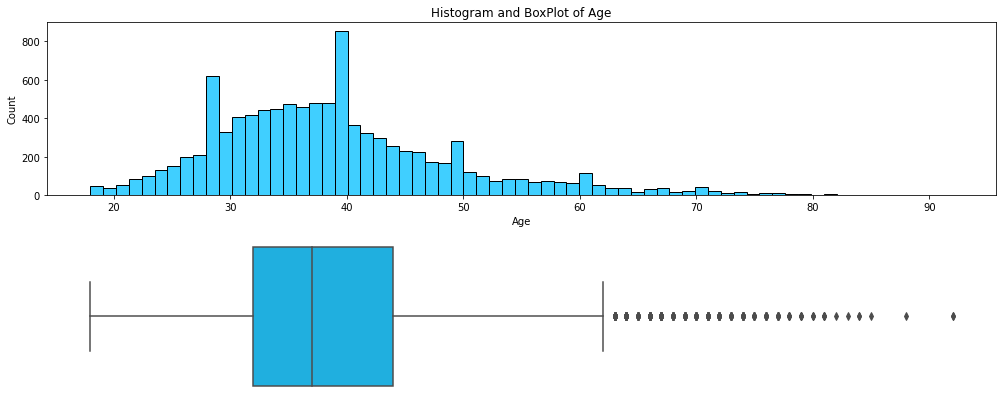

In [37]:
distribution_plot(df.Age, 'Age')

In [51]:
# Let's draw plots!
import statsmodels.api as sm
import scipy

# Let's take the price feature from Renthop dataset and filter by hands the most extreme values for clarity

age = df['Age']
age_log = np.log(df['Age'])

# A lot of gestures so that sklearn didn't shower us with warnings
age_mm = (
    MinMaxScaler()
    .fit_transform(age.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)
age_z = (
    StandardScaler()
    .fit_transform(age.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)

age_bc = scipy.stats.boxcox(age)[0]

Q-Q plot of the initial feature

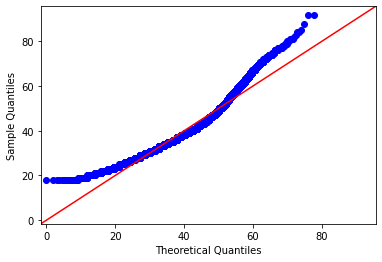

In [42]:
fig = sm.qqplot(age, loc=age.mean(), scale=age.std(), line ='45')

Q-Q график признака после StandartScaler. Форма не меняется

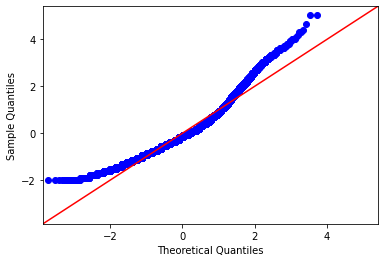

In [43]:
fig = sm.qqplot(age_z, loc=age_z.mean(), scale=age_z.std(), line ='45')

Q-Q график признака после MinMaxScaler. Форма не меняется

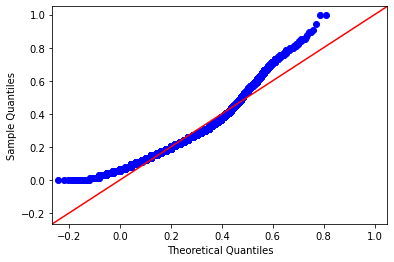

In [46]:
fig = sm.qqplot(age_mm, loc=age_mm.mean(), scale=age_mm.std(), line ='45')

Q-Q график признака после логарифмирования. Дела пошли на поправку!

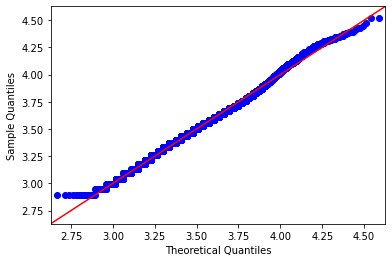

In [47]:
fig = sm.qqplot(age_log, loc=age_log.mean(), scale=age_log.std(), line ='45')

Q-Q график признака после преобразования Бокса-Кокса.

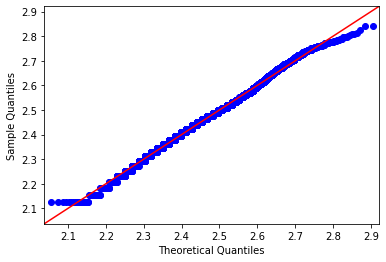

In [54]:
fig = sm.qqplot(age_bc, loc=age_bc.mean(), scale=age_bc.std(), line ='45')

![image](https://cdn-images-1.medium.com/max/800/0*Ps-v8F0fBgmnG36S.)


# Отбор признаков (Feature selection)

Зачем отбирать признаки? Можно выделить несколько причин:

1) для уменьшения вычислительной сложности расчетов (в реальной задаче признаков может быть сотни и даже тысячи)

2) меньше признаков - меньше вероятность, что что-то сломается

3) меньше признаков - проще интерпретировать результаты модели

4) некоторые алгоритмы склонны переобучаться на неинформативных признаках


### Статистические подходы

Самый простой подход - это убирать признаки низкой вариативности (дисперсии).

In [5]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [58]:
VarianceThreshold(0.7).fit_transform(x_data_generated).shape

(100, 20)

In [59]:
VarianceThreshold(0.8).fit_transform(x_data_generated).shape

(100, 17)

In [60]:
VarianceThreshold(0.9).fit_transform(x_data_generated).shape

(100, 15)

Есть и другие способы

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=10).fit_transform(
    x_data_generated, y_data_generated
)
x_data_varth = VarianceThreshold(0.9).fit_transform(x_data_generated)

In [15]:
logit = LogisticRegression(solver="lbfgs", random_state=17)

In [74]:
cross_val_score(
    logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.49195067212349547

In [75]:
cross_val_score(
    logit, x_data_kbest, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.4209839800070741

In [76]:
cross_val_score(
    logit, x_data_varth, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.4542963589116155

### Отбор с использованием моделей

Другой подход: использовать какую-то baseline модель для оценки признаков, при этом модель должна явно показывать важность использованных признаков. Обычно используются два типа моделей: какая-нибудь "деревянная" композиция (например, Random Forest) или линейная модель с Lasso регуляризацией, склонной обнулять веса слабых признаков. Логика интутивно понятна: если признаки явно бесполезны в простой модели, то не надо тянуть их и в более сложную.

In [27]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification(1000)

rf = RandomForestClassifier(n_estimators=10, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), logit)

print(
    cross_val_score(
        logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        rf, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        pipe, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)

-0.3105803669432121
-0.8144986485849571
-0.30143437855620325


Нельзя забывать, что это тоже не серебряная пуля — может получиться даже хуже.

In [8]:
from sklearn.preprocessing import LabelEncoder

df['Geography'] = LabelEncoder().fit_transform(df['Geography'], )
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Surname'] = LabelEncoder().fit_transform(df['Surname'])

In [88]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,289,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [17]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Surname',
            'Geography', 'Gender']

x_data = df[features]
y_data = df['Exited']

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=rf), logit)

pipe2 = make_pipeline(StandardScaler(), logit)

pipe3 = make_pipeline(SelectFromModel(estimator=rf), rf)

print(
    "LR + selection: ",
    cross_val_score(pipe1, x_data, y_data, scoring="neg_log_loss", cv=5).mean(),
)
print(
    "LR: ", cross_val_score(pipe2, x_data, y_data, scoring="neg_log_loss", cv=5).mean()
)
print(
    "RF + selection: ", cross_val_score(pipe3, x_data, y_data, scoring="neg_log_loss", cv=5).mean()
    )
print(
    "RF: ", cross_val_score(rf, x_data, y_data, scoring="neg_log_loss", cv=5).mean()
    )


LR + selection:  -0.46040297392476204
LR:  -0.43619518809770225
RF + selection:  -1.1396321343787972
RF:  -0.9346590244226934


Так же можно использовать permutation feature importance для отбора признаков, но в этой случае модель должна быть близка к той, которую вы планируете использовать.

In [33]:
from sklearn.inspection import permutation_importance
x_data_scaled = StandardScaler().fit_transform(df[features])

logit.fit(x_data_scaled, y_data)

scoring  = ['neg_log_loss']
r = permutation_importance(logit, x_data_scaled, y_data,
                           n_repeats=5,
                           scoring =scoring,
                           random_state=0)
r = r['neg_log_loss']
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")


Age      0.092  +/- 0.002
IsActiveMember 0.040  +/- 0.001
Balance  0.014  +/- 0.001
Gender   0.010  +/- 0.001
Geography 0.001  +/- 0.000
CreditScore 0.000  +/- 0.000
EstimatedSalary 0.000  +/- 0.000


### Перебор
Наконец, самый надежный, но и самый вычислительно сложный способ основан на банальном переборе: обучаем модель на подмножестве "фичей", запоминаем результат, повторяем для разных подмножеств, сравниваем качество моделей. Такой подход называется [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).

Перебирать все комбинации – обычно слишком долго, так что можно пробовать уменьшить пространство перебора. Фиксируем небольшое число N, перебираем все комбинации по N признаков, выбираем лучшую комбинацию, потом перебираем комбинации из N+1 признаков так, что предыдущая лучшая комбинация признаков зафиксирована, а перебирается только новый признак. Таким образом можно перебирать, пока не упремся в максимально допустимое число признаков или пока качество модели не перестанет значимо расти. Этот алгоритм называется [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

Этот же алгоритм можно развернуть: начинать с полного пространства признаков и выкидывать признаки по одному, пока это не портит качество модели или пока не достигнуто желаемое число признаков.

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     n_features_to_select=3, direction='forward', 
                                     n_jobs=-1)

x_data_scaled = StandardScaler().fit_transform(df[features])
selector.fit(x_data_scaled, y_data)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=3, n_jobs=-1,
                          scoring='neg_log_loss')

In [26]:
np.array(features)[selector.get_support()]

array(['Age', 'Balance', 'IsActiveMember'], dtype='<U15')

Ссылки:


*   https://habr.com/ru/company/ods/blog/325422/
*   https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

